## This is the script to work with the quora dataset
The code is a copy of https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


* Dataset consists of over 400,000 lines of potential question duplicate pairs.
* Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.
* Data Fields:

    id - the id of a training set question pair

    qid1, qid2 - unique ids of each question (only available in train.csv)

    question1, question2 - the full text of each question

    is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

The sample of the data is as follows

![image](https://qph.fs.quoracdn.net/main-qimg-ea50c7a005eb7750af0b53b07c8caa60)



The goal is to use this data and formulate it into a __seq2seq problem__. In this regards we have formulated the following problem statement

**Problem Statement**

Given the Quora dataset, take out the questions pairs where question1 is a duplicate of question2 basically where __is_duplicate=1__. 

Now the seq2seq problem can be formulated as given question1 to the encoder, decoder should be able to find out the corresponding question2. (This is similar to saying given an english statement find the equivalent french statement)


**Approach**

1. Convert the quora dataset to a seq2seq network compatible dataset
2. Read the data into the network 
3. Train the network using the example code
4. Evaluate the training accuracy


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

## Create the dataset
1. read the quora original data set and convert it to the q1,q2 pairs
2. in order to reuse the data preparation code we need to save it to a tab separated file


In [44]:
## make the dataset 
quoraDF=pd.read_csv("data/quora_raw_train.csv")
quoraDF=quoraDF[quoraDF['is_duplicate']==1][['question1','question2']]
quoraDF.head()
## save it to the file
quoraDF.to_csv("data/quora_similar_questions.txt",sep="\t",index=False)

### Dataset preparation code as copy pasted. 
Lang1, Lang2 refer to question1 and question2

**minor changes**
1. we are not filering out on the basis of the eng_prefixes
2. also the file name has been hardcoded instead of picking as the languge names


In [20]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [45]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [46]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/quora_similar_questions.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [48]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('quest1', 'quest2')
print(random.choice(pairs))

Reading lines...
Read 149264 sentence pairs
Trimmed to 44289 sentence pairs
Counting words...
Counted words:
quest1 13298
quest2 13275
['which is the strongest character in mahabharata ?', 'who was the strongest character in mahabharata ?']


## Encoder class 
It follows are basic architecture of Input Tensor >> Emebedding Layer >> GRU

Refer to the diagram 
![image](img/encoder.png)


In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Mechanism

This is the main class that defines the attention mechanism along with the decoder part

The attention has been calculated little differently than the usual method (Additive Attention). 

I will explain both the ways

1. Attention architecture as used in the code:
![image](img/attention_architecture_example.png)



Following is the approach

1. Calculate the attention weights which is set of $\alpha$s. We make use of $D_t\__1$ which is the previous hidden state and the input at time t which is same as Output of the previous state. we denote it as $O_t\__1$ 
so Attention weight is a function of  $D_t\__1$ & $O_t\__1$ 

2. Now $D_t\__1$ & $O_t\__1$  is passed to a FC to get a set of paramters that can be trained in order to find the real values of set of $\alpha$ => $\{α_1,\alpha_2....\alpha_N\} $

![image](img/attention_weights1.png)


3. The attention weights are then applied to the Encoded_Outputs which is essentially all the hidden states of the Encoder so that we can now choose which all Encoder outputs are going to affect the Decoder most. The attention is essentially a set of weights to pick up the right percentage of the Encoder_outputs

  $\alpha . E_o $.. this is esentially equal to $\alpha_1 * E_1 + \alpha_2*E_2 +....\alpha_N* E_N $

  the above step is also called the __attention applied__ and is performed by a special function called __BMM__.  $\alpha . E_o $ is also called the __Context Vector__

4. Now we have the weighted effect of Encoder outputs ready . So we combine it with the input of the decoder which is $O_t\__1$
So basically $[O_t\__1,\alpha.E_o]$
This step is also called the __attention_combined__

5. The __attention_combined__ is sent to the GRU and the output & hidded i.e. $O_t$ & $D_t$ for the state t are obtained

Now the __biggest concern__ is the attention step which is step2. Why are hidden state combined with the input. They will be almost the same . The idea is to check the effect of Encoder states on the decoder states and so attention should be calculated using Encoder outputs rather than the Decoder Output



### Alternate approach. (additive Attention)

The main difference is the paramters that are used to create the attention weights

The attention is calculated using the $D_t\__1$ and Encoder_Outputs ($E_o$)

So the attention block will look like the following
![image](img/attention_weights2.png)


And then the Set of alphas are combined with the Encoder_outputs to get the __Context Vector__ or what was called earlier as __attention_applied__ done using __bmm__

Other steps remains more or less similar

The major advantage is that the alphas are learnt after the interaction between the decoder and the Encoder which is what we wanted that decoder should find out how much different Encoder Outputs are required for the new prediction
The following is the complete architecture

![image](img/attention_calculation_Additive.png)




In [6]:
## this class is implementing the additive attention given by
## attn_weights=softmax(W_combined*tanh(W_decoder*decoder_hidden+W_Encoder*encoder_values))
class AdditiveAttention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim):
        super(AdditiveAttention,self).__init__()
        #256 this is the dimention of the D(t-1)
        self.decoder_dim=decoder_dim 
        ## the diemtion of each outut of the encoder...this in our case is 256 
        self.encoder_dim=encoder_dim
        ## this is one of the weight matrix that will be sed to combine the weitghs
        self.W_Combined = torch.nn.Parameter(
            torch.FloatTensor(self.decoder_dim).uniform_(-0.1, 0.1)) 
        #FC to add a weight matrix W_decoder for the Decoder_Hidden
        self.W_Decoder = torch.nn.Linear(decoder_dim, decoder_dim)
        #FC to add a weight matrix to the encoder_values
        self.W_EncoderOutput = torch.nn.Linear(encoder_dim, decoder_dim)

    ##query and values is a generic terms used in case of attention 
    def get_weights(self,        
        query: torch.Tensor,  # query = decoder hidden
        values: torch.Tensor,  # encoder output of the form maxLength*encoder_dim in ou r case it is 10x256
    ):
        attn_weights = self.W_Decoder(query) + self.W_EncoderOutput(values)  # [max_length, decoder_dim]
        return F.softmax((torch.tanh(attn_weights) @ self.W_Combined),dim=1) # [1,max_length]

In [7]:
## this is another way of implementing the attention. In this case the attention is given by 
## attn_weight=softmax(decoder_hidden*W*encoder_values)

class MultiplicativeAttention(nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super(MultiplicativeAttention,self).__init__()
        ##256
        self.decoder_dim=decoder_dim
        ##dimention of each encoder output 256
        self.encoder_dim=encoder_dim
        ## weight vector of size 256
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [1,max_length]
        return F.softmax((weights/np.sqrt(self.decoder_dim)),dim=1)  # [1,max_length]

In [8]:
## this is what has been used in the code https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
## basically the attention is given by  softmax(W*(Decoder_input_attime_t + Decoder_hidden_attime_t-1))
class PytorchAttention(nn.Module):

    def __init__(self, max_length, decoder_dim):
        super(PytorchAttention,self).__init__()
        #256 this is the dimention of the D(t-1)
        self.decoder_dim=decoder_dim 
        # the  maximul legth of the sequence..in our case it is 10
        self.max_length=max_length 
        ## this will add a Weight
        self.attn = nn.Linear(self.decoder_dim * 2, self.max_length)
       
    def get_weights(self,        
        
        hidden: torch.Tensor,  #decoder hidden at time t-1                  
        embedded: torch.Tensor #decoder input at time t
    ):
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded, hidden), 1)), dim=1)  # [1,seq_length]
        return attn_weights

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, attentionType="Pytorch",dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
         ## this is different from the original code
        self.attentionType=attentionType
        if(self.attentionType=="Multiplicative"):
            self.attention = MultiplicativeAttention(self.hidden_size,self.hidden_size)
        elif(self.attentionType=="Additive"):
            self.attention = AdditiveAttention(self.hidden_size,self.hidden_size)
        elif(self.attentionType=="Pytorch"):
            self.attention = PytorchAttention(self.max_length,self.hidden_size)
       

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        
        if(self.attentionType=="Multiplicative"):
            attn_weights=self.attention.get_weights(hidden[0],encoder_outputs)
        elif(self.attentionType=="Additive"):
            attn_weights=self.attention.get_weights(hidden[0],encoder_outputs.unsqueeze(0))
        elif(self.attentionType=="Pytorch"):
            attn_weights = self.attention.get_weights(hidden[0],embedded[0])
        

        
        
#         attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [28]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#### we are making use of the Teacher Forcing which is a way of sending the actual ground truth while the trainign is going on

In [29]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### utility function for capturing the time of  execution

In [50]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [31]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [32]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [33]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

### function to fetch the random samples and evaluate the accuracy

In [34]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### the actual training starts here with 75000 epochs

In [37]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,attentionType="Pytorch", dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)


1m 22s (- 19m 20s) (5000 6%) 4.3533
2m 42s (- 17m 37s) (10000 13%) 3.8265
4m 3s (- 16m 13s) (15000 20%) 3.5220
5m 23s (- 14m 49s) (20000 26%) 3.3943
6m 44s (- 13m 28s) (25000 33%) 3.2572
8m 4s (- 12m 7s) (30000 40%) 3.1121
9m 25s (- 10m 46s) (35000 46%) 3.0206
10m 46s (- 9m 25s) (40000 53%) 2.9435
12m 6s (- 8m 4s) (45000 60%) 2.8835
13m 27s (- 6m 43s) (50000 66%) 2.8100
14m 47s (- 5m 22s) (55000 73%) 2.7668
16m 8s (- 4m 2s) (60000 80%) 2.7245
17m 29s (- 2m 41s) (65000 86%) 2.6653
18m 50s (- 1m 20s) (70000 93%) 2.5953
20m 10s (- 0m 0s) (75000 100%) 2.5659


In [52]:
## check the results 
evaluateRandomly(encoder1, attn_decoder1)

> why do many muslims hate rss ?
= why most of the muslims hate rss ?
< why do india hate ? <EOS>

> why does nobody like nickelback ?
= why do so many people dislike nickelback ?
< why do some people like dogs ? <EOS>

> how can i overcome sadness after a breakup ?
= how do i overcome depression after breakup ?
< how can i overcome to to ? ? <EOS>

> what is the latest computer programming language ?
= what are the latest programming languages ?
< what is the programming language language ? ? <EOS>

> how can i use quora to make money ?
= do bloggers on quora earn money ?
< how do i ways money from ? ? <EOS>

> why is saltwater taffy candy imported in germany ?
= why is saltwater taffy candy imported in brazil ?
< why is saltwater taffy candy imported in ? <EOS>

> how can i understand english ?
= how can i become good at english ?
< how can i learn english english ? <EOS>

> how did donald trump win the elections ?
= how did donald trump win ?
< how did trump trump the the election ?

### code to visually see the attention while performing the translations

In [54]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)




input = what is are your new year resolutions for
output = what s your new year resolutions for ? <EOS>


/home/gauravp/python36/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/gauravp/python36/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


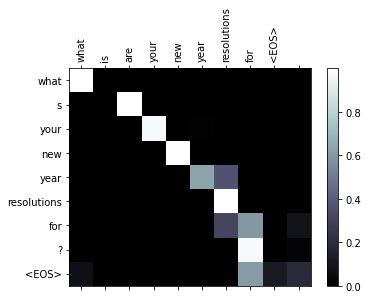

In [58]:
evaluateAndShowAttention("what is are your new year resolutions for")
